<a href="https://colab.research.google.com/github/sakshamg94/CEE262I_OceanCirculation/blob/master/final_project_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### _Final Project — CEE 262I




# Exploring monthly mean SSH, SST and winds
analyzing monthly averages of SST, SSH and surface winds from the month of November 2018 (for now). The location I have chosen is the region off the coast of southern Africa (including Madagascar) extending all the way to the western coast of Africa. This zone extends from 5$^{\circ}$S-40$^{\circ}$S in the zonal direction and 30$^{\circ}$E-120$^{\circ}$E in the meridional direction. I intend to analyze a time series time permitting. 

In [0]:
%%capture
!pip install gsw
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install ffmpeg-python

Then, you need to mount your Google Drive to access the data files. Run the cell below and copy/paste your authorization code as required.

In [240]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


You can now import the packages and paths that you will use by running the cell below:

In [0]:
import sys
import os
sys.path.append('/content/drive/My Drive/CEE262I_OceanCirculation/netcdf')
sys.path.append('/content/drive/My Drive/ESS246B_CEE262I/python')

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
import gsw
from py_funcs_hw3 import *
from py_funcs_hw2 import *
from py_funcs_hw4 import *
import ffmpeg
import datetime
import pandas as pd
import calendar

%matplotlib inline

In [0]:
import matplotlib
import matplotlib.colors as colors

#http://chris35wills.github.io/matplotlib_diverging_colorbar/
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

The COPERNICUS MARINE ENVIRONMENT MONITORING SERVICE (CMEMS) was used to obtain data (http://marine.copernicus.eu ). Here, I use the 4 dimensional data from Global ARMOR3D Reprocessed monthly dataset to look at the Sea Surface Height (SSH), SST

In [243]:
### CMEMS DATA
base_ds = xr.open_dataset('drive/My Drive/CEE262I_OceanCirculation/netcdf/dataset-armor-3d-rep-monthly_1583446978114.nc')
lon_base = base_ds['longitude'][:]-360  # longitude
lat_base = base_ds['latitude'][:]  # latitude
time_base = base_ds['time'][:]  # time
depth_base = base_ds['depth'][:]# depth
print(base_ds)
print(lat_base.shape,  np.max(lat_base), np.min(lat_base))
print(lon_base.shape,  np.max(lon_base), np.min(lon_base))
print(time_base.shape, time_base[0], time_base[-1])
print(depth_base.shape, depth_base[0], depth_base[-1])

<xarray.Dataset>
Dimensions:    (depth: 33, latitude: 141, longitude: 361, time: 47)
Coordinates:
  * depth      (depth) int16 0 10 20 30 50 75 ... 3000 3500 4000 4500 5000 5500
  * latitude   (latitude) float32 -39.875 -39.625 -39.375 ... -5.125 -4.875
  * time       (time) datetime64[ns] 2015-01-15 2015-02-15 ... 2018-11-15
  * longitude  (longitude) float32 29.875 30.125 30.375 ... 119.625 119.875
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    zo         (time, depth, latitude, longitude) float32 ...
    to         (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    ugo        (time, depth, latitude, longitude) float32 ...
    vgo        (time, depth, latitude, longitude) float32 ...
Attributes:
    title:             ARMOR3D REP - TSHUVMld Global Ocean Observation-based ...
    description:       ARMOR3D REP CMEMS - April 2019 Release
    Conventions:       CF-1.0
    institution:       CLS
   

### Dependent Variables

In [244]:

print(base_ds['to'][:].units, base_ds['zo'][:].units, base_ds['so'][:].units) 
print(base_ds['to'][:].shape, base_ds['zo'][:].shape, base_ds['so'][:].shape) 



degrees_C m 0.001
(47, 33, 141, 361) (47, 33, 141, 361) (47, 33, 141, 361)


In [245]:
mo = -1
SSH = base_ds['zo'][mo,0,:,:].T  # Sea Surface Height where zo is 4 dimensional : (latest time, depth, latitude, longitude)
SST = base_ds['to'][mo,0,:,:].T  # SS Temperature where to is 4 dimensional: (latest time, depth, latitude, longitude)
print(SSH.shape, SSH.units, np.max(SSH), np.min(SSH))
print(SST.shape, SST.units, np.max(SST), np.min(SST))

currDate_ds = [calendar.month_abbr[pd.DatetimeIndex(time_base.values[:])[mo].month], 
            pd.DatetimeIndex(time_base.values[:])[mo].year, pd.DatetimeIndex(time_base.values[:])[mo].day]
print(currDate_ds)

(361, 141) m <xarray.DataArray 'zo' ()>
array(1.60900009)
Coordinates:
    depth    int16 0
    time     datetime64[ns] 2018-11-15 <xarray.DataArray 'zo' ()>
array(0.24900001)
Coordinates:
    depth    int16 0
    time     datetime64[ns] 2018-11-15
(361, 141) degrees_C <xarray.DataArray 'to' ()>
array(30.59300041)
Coordinates:
    depth    int16 0
    time     datetime64[ns] 2018-11-15 <xarray.DataArray 'to' ()>
array(11.30999947)
Coordinates:
    depth    int16 0
    time     datetime64[ns] 2018-11-15
['Nov', 2018, 15]


0.2 1.6


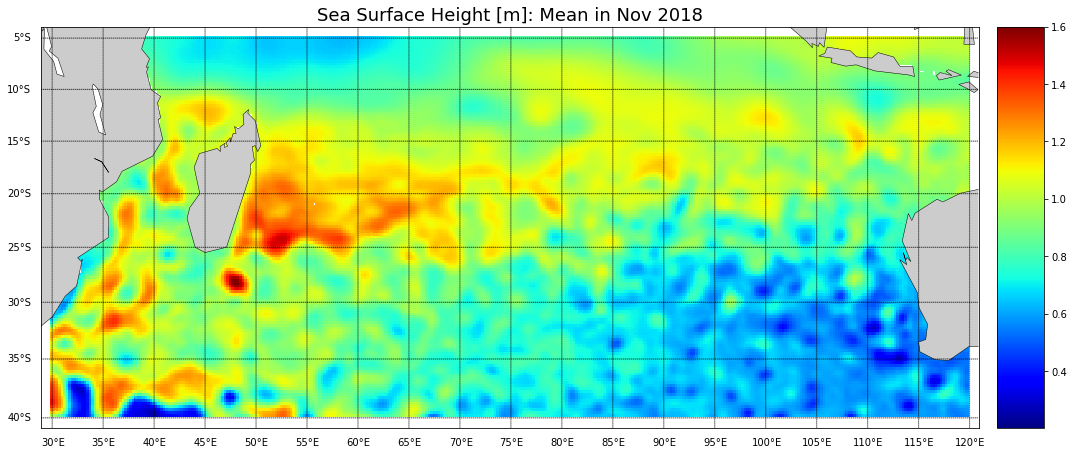

11.3 30.6


<Figure size 432x288 with 0 Axes>

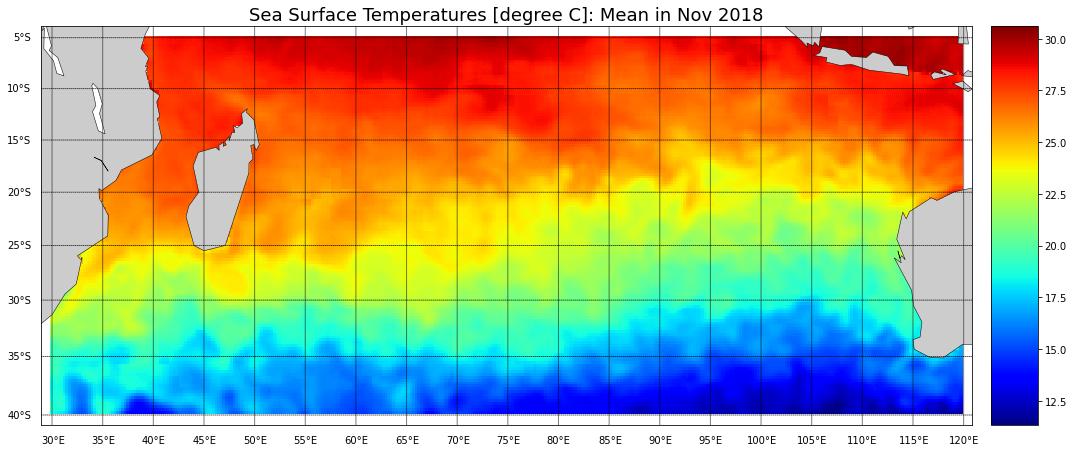

In [250]:
sshPath = '/content/drive/My Drive/CEE262I_OceanCirculation/SSH'

### PLOT SSH for the time stamp of interest
plt.figure(figsize=(15.,16.))
lon_2D, lat_2D = np.meshgrid(lon_base, lat_base, indexing='ij')
m = Basemap(projection='mill', 
            llcrnrlat=np.min(lat_base)-1, urcrnrlat=np.max(lat_base)+1, 
            llcrnrlon=np.min(lon_base)-1, urcrnrlon=np.max(lon_base)+1, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
SSH_min_lev = round(np.nanmin(SSH),1)
SSH_max_lev = round(np.nanmax(SSH),1)
print(SSH_min_lev, SSH_max_lev)
cmesh = m.pcolormesh(lon_2D, lat_2D, SSH, cmap='jet', latlon=True, vmin=SSH_min_lev, vmax=SSH_max_lev)
cbar = m.colorbar(cmesh, location='right')
plt.title('Sea Surface Height [m]: Mean in {} {}'.format(currDate_ds[0], currDate_ds[1]), fontsize=18)
plt.tight_layout()
plt.savefig('{}_{}_{}_{}.png'.format(sshPath, currDate_ds[1], currDate_ds[0], currDate_ds[2]))
plt.show()

### PLOT SST for the  same time stamp of interest
plt.figure(figsize=(15.,16.))
m = Basemap(projection='mill', 
            llcrnrlat=np.min(lat_base)-1, urcrnrlat=np.max(lat_base)+1, 
            llcrnrlon=np.min(lon_base)-1, urcrnrlon=np.max(lon_base)+1, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
SST_min_lev = round(np.nanmin(SST),1)
SST_max_lev = round(np.nanmax(SST),1)
print(SST_min_lev, SST_max_lev)
cmeshT = m.pcolormesh(lon_2D, lat_2D, SST, cmap='jet', latlon=True, vmin=SST_min_lev, vmax=SST_max_lev)
cbar = m.colorbar(cmeshT, location='right')
plt.title('Sea Surface Temperatures [degree C]: Mean in {} {}'.format(currDate_ds[0], currDate_ds[1]), fontsize=18)
plt.tight_layout()
plt.show()


In [0]:
out,_ = (
    ffmpeg
    .input(os.path.join(sshPath,'*.png'), pattern_type='glob', framerate=25)
    .output('movie.mp4')
    .run()
)

## Wind Data

The CMEMS website was again used to obtain surface wind data. Here i used Global Ocean Wind L4 Reprocessed Monthly Mean Observations. Monthly average wind data here is 3 dimensional with wind velocities measured 10 m above the free surface

In [215]:
ws_ds = xr.open_dataset('/content/drive/My Drive/CEE262I_OceanCirculation/netcdf/CERSAT-GLO-REP_WIND_L4-OBS_FULL_TIME_SERIE_1583447823722.nc')
print(ws_ds)
lon_1D = ws_ds['longitude'][:].values-360
lat_1D = ws_ds['latitude'][:].values
time_ws = ws_ds['time'][:].values  # time
depth_ws = ws_ds['depth'][:].values# depth
print(depth_ws.shape, depth_ws[0], depth_ws[-1])


<xarray.Dataset>
Dimensions:                                (depth: 1, latitude: 141, longitude: 361, time: 47)
Coordinates:
  * time                                   (time) datetime64[ns] 2015-01-01T12:00:00 ... 2018-11-01T12:00:00
  * depth                                  (depth) float32 10.0
  * latitude                               (latitude) float32 -39.875 ... -4.875
  * longitude                              (longitude) float32 30.125 ... 120.125
Data variables:
    surface_downward_eastward_stress       (time, depth, latitude, longitude) float32 ...
    wind_stress_rms                        (time, depth, latitude, longitude) float32 ...
    northward_wind                         (time, depth, latitude, longitude) float32 ...
    land_ice_mask                          (time, depth, latitude, longitude) float32 ...
    sampling_length                        (time, depth, latitude, longitude) float32 ...
    eastward_wind_std                      (time, depth, latitude, longit

In [0]:

# Get lat-lon grid
lon, lat = np.meshgrid(lon_1D, lat_1D, indexing='ij')
Nx, Ny = lon.shape

# Limit entire domain
lon_max = (120-360)
lon_min = (30-360)
lat_max = -5
lat_min = -40
domain = ((lon>=lon_min) & (lon<=lon_max) & (lat>=lat_min) & (lat<=lat_max))


In [217]:
# Extract the Wind Stress monthly average for the latest month (same as that for the SSH and SST data)
it = -1
currDate = [calendar.month_abbr[pd.DatetimeIndex(time_base.values[:])[it].month], 
            pd.DatetimeIndex(time_base.values[:])[it].year]
print(currDate)

assert(currDate==currDate_ds)

EWind = ws_ds['surface_downward_eastward_stress'][it,0,:,:]
NWind = ws_ds['surface_downward_northward_stress'][it,0,:,:]
print(EWind.shape, EWind.units)
print(NWind.shape, NWind.units)

taux = EWind.values.T
taux[domain==0] = np.nan
tauy = NWind.values.T
tauy[domain==0] = np.nan

taux_min = np.nanmin(taux)
taux_max = np.nanmax(taux)
tauy_min = np.nanmin(tauy)
tauy_max = np.nanmax(tauy)
taux_lim = round(max(abs(taux_min), abs(taux_max)), 1)
print(taux_lim)
tauy_lim = round(max(abs(tauy_min), abs(tauy_max)), 1)
print(tauy_lim)

['Nov', 2018]
(141, 361) Pa
(141, 361) Pa
0.2
0.2


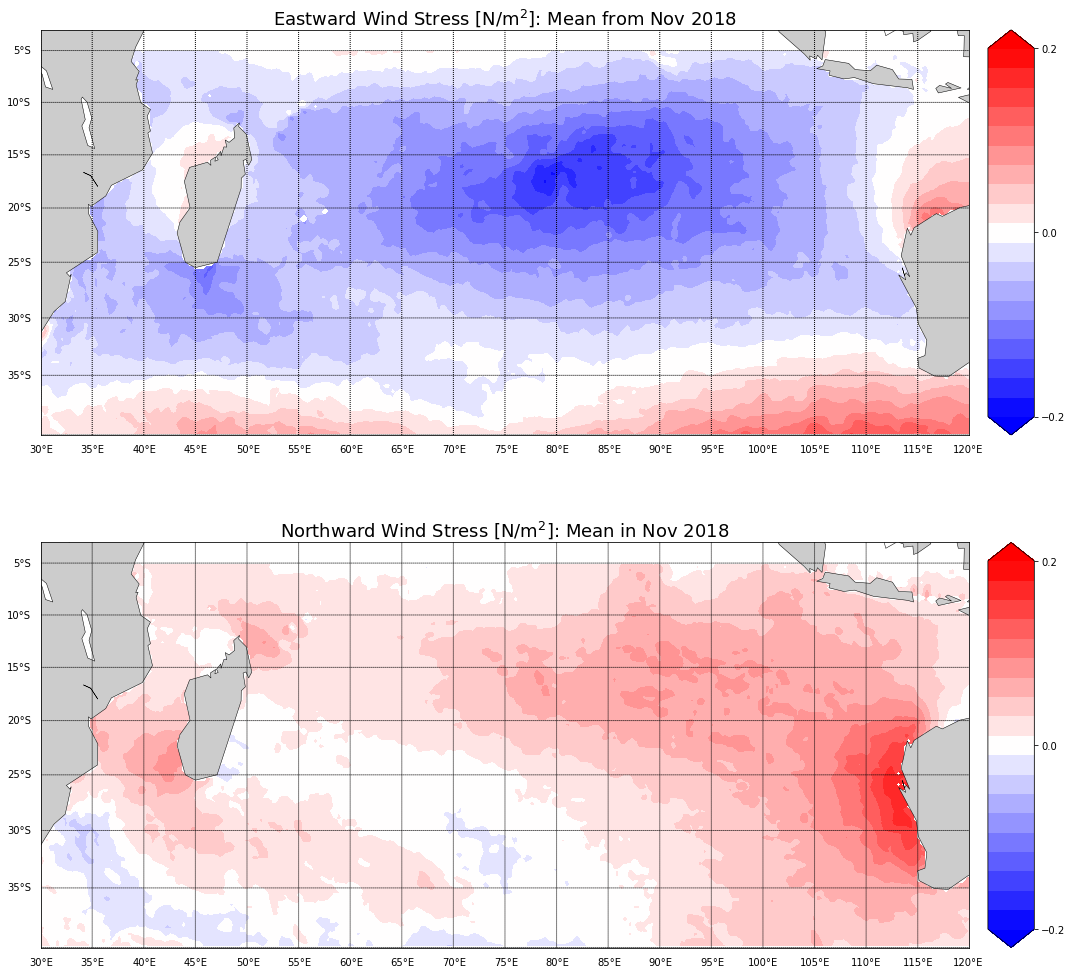

In [218]:
### PLOT
plt.figure(figsize=(15.,16.))

plt.subplot(2,1,1)
m = Basemap(projection='mill', 
            llcrnrlat=lat_min, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min, urcrnrlon=lon_max, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
levs = np.linspace(-taux_lim, taux_lim, 20)
cmesh = m.contourf(lon, lat, taux, levs, cmap='bwr', latlon=True, extend='both')
cbar = m.colorbar(cmesh, ticks=[-taux_lim, 0, taux_lim], location='right')
plt.title('Eastward Wind Stress [N/m$^2$]: Mean from {} {}'.format(currDate[0], currDate[1]), fontsize=18)
plt.tight_layout()

plt.subplot(2,1,2)
m = Basemap(projection='mill', 
            llcrnrlat=lat_min, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min, urcrnrlon=lon_max, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
levs = np.linspace(-tauy_lim, tauy_lim, 20)
cmesh = m.contourf(lon, lat, tauy, levs, cmap='bwr', latlon=True, extend='both')
cbar = m.colorbar(cmesh, ticks=[-tauy_lim, 0, tauy_lim], location='right')
plt.title('Northward Wind Stress [N/m$^2$]: Mean in {} {}'.format(currDate[0], currDate[1]), fontsize=18)
plt.tight_layout()

plt.show()

### Ekman transport

In [219]:
# Constants
Omega = 2*np.pi/86400  # Earth's angular velocity
rho_ref = 1000.  # reference density
deg2rad = np.pi/180  # conversion factor from degree to radian
R = 6371e3 # Earth's radius

### START CODE HERE ###

# Grid spacing in the zonal and meridional directions in meters (~2 lines of code)
dx = R*np.cos(lat_1D*deg2rad)*(lon_1D[1]-lon_1D[0])*deg2rad
dy = R*(lat_1D[1]-lat_1D[0])*deg2rad
print(lat_1D.shape, "number of latitudes", np.max(lat_1D), np.min(lat_1D))
print(lon_1D.shape, "number oflongitudes", np.max(lon_1D), np.min(lon_1D))
print(np.max(lat_1D[:-1]-lat_1D[1:]),np.min(lat_1D[:-1]-lat_1D[1:]))
print(np.max(lon_1D[:-1]-lon_1D[1:]),np.min(lon_1D[:-1]-lon_1D[1:]))

# Calculate the Ekman transport in each direction (~3 lines of code)
f = 2*Omega*np.sin(lat_1D*deg2rad)
Mx = tauy/f
My =-taux/f
print(Mx.shape, My.shape)

(141,) number of latitudes -4.875 -39.875
(361,) number oflongitudes -239.875 -329.875
-0.25 -0.25
-0.25 -0.25
(361, 141) (361, 141)


### Ekman vertical velocity (working on more focussed plots still)

(361, 141) (361, 141) (361, 141) (141,) () (361,) (361, 141)
1.3


/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:3128: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0


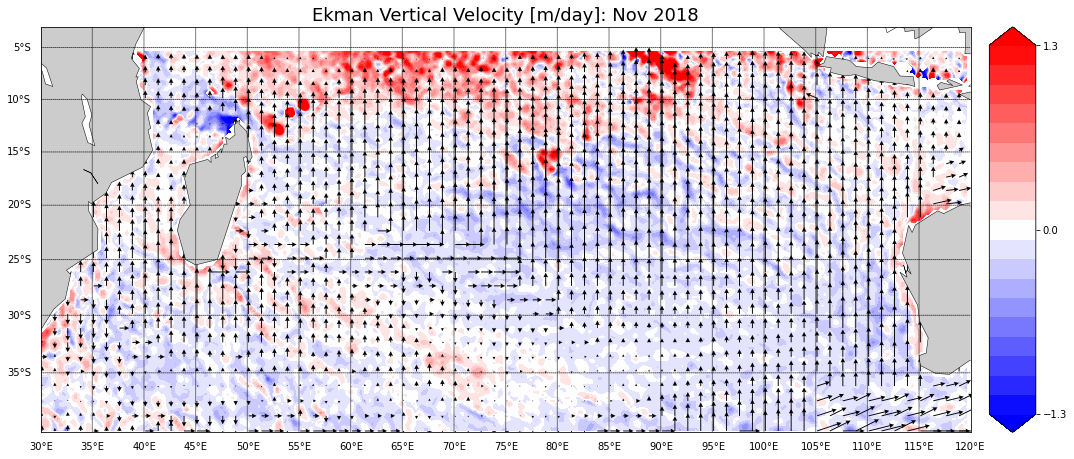

In [220]:
# Calculate the corresponding Ekman Vertical velocity in m/day (~5 lines of code)
dMxdx = np.zeros((Nx,Ny))
print(dMxdx.shape, Mx.shape, My.shape, dx.shape, dy.shape, Mx[:,1].shape, np.gradient(My,dy,axis=1).shape)

for ky in range(Ny):
    dMxdx[:,ky] = np.gradient(Mx[:,ky],dx[ky], axis=0)
dMydy = np.gradient(My,dy, axis=1)
we = 1/rho_ref*(dMxdx + dMydy)*86400 # in m/day
welim = round(0.16*max(abs(np.nanmax(we)), abs(np.nanmin(we))), 1) #0.16 is randomly chosen
print(welim)
### 

### PLOT
plt.figure(figsize=(15.,16.))

m = Basemap(projection='mill', 
            llcrnrlat=lat_min, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min, urcrnrlon=lon_max, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
levs = np.linspace(-welim, welim, 20)
cmesh = m.contourf(lon, lat, we, levs, cmap='bwr', latlon=True, extend='both')
cbar = m.colorbar(cmesh, ticks=[-welim, 0, welim], location='right')
taux2,tauy2,lon2,lat2 = m.rotate_vector(taux,tauy,lon,lat,returnxy=True)
skip=(slice(None,None,5),slice(None,None,5))
m.quiver(lon2[skip], lat2[skip], taux2[skip], tauy2[skip], width=0.001, scale=5, headwidth=5) #)
plt.title('Ekman Vertical Velocity [m/day]: {} {}'.format(currDate[0], currDate[1]), fontsize=18)

plt.tight_layout()
plt.show()

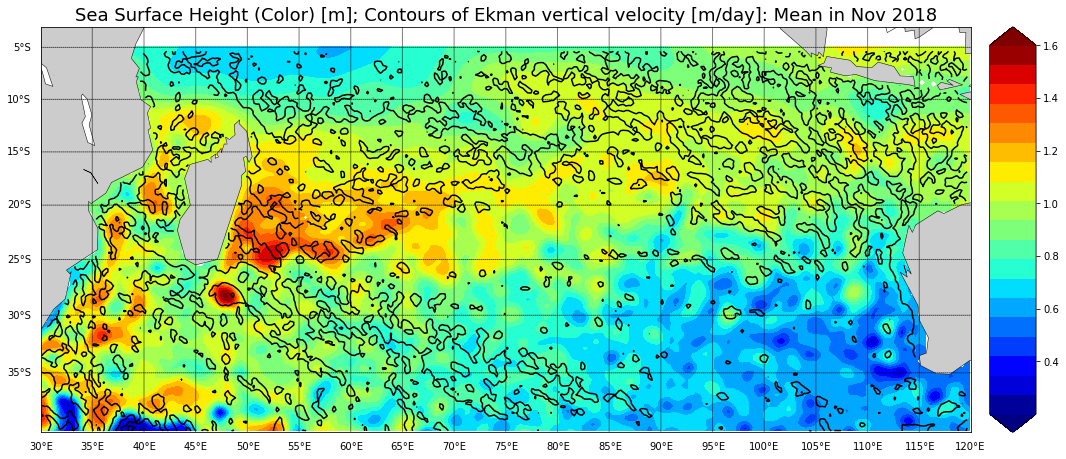

In [221]:
### PLOT
plt.figure(figsize=(15.,16.))
lon_2D, lat_2D = np.meshgrid(lon_base, lat_base, indexing='ij')
m = Basemap(projection='mill', 
            llcrnrlat=lat_min, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min, urcrnrlon=lon_max,  
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])

SSH_min_lev = round(np.nanmin(SSH),1)
SSH_max_lev = round(np.nanmax(SSH),1)
levs = np.linspace(SSH_min_lev, SSH_max_lev, 20)

cmesh = m.contourf(lon_2D, lat_2D, SSH, levs, cmap='jet', latlon=True, extend='both')
cbar = m.colorbar(cmesh, ticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2], location='right')

skip2=(slice(None,None,1),slice(None,None,1))
m.contour(lon2[skip2], lat2[skip2], we[skip2], 0, colors='black')
plt.title('Sea Surface Height (Color) [m]; Contours of Ekman vertical velocity [m/day]: Mean in {} {}'.format(currDate[0], currDate[1]), fontsize=18)
plt.tight_layout()
plt.show()

### Wind Data and Sverdrup Balance

In [222]:
# Extract the Wind Stress monthly average for the latest month (same as that for the SSH and SST data)
yearID = 3 # 0-2015, 1-2016, ... 3-2018
timeStartId = yearID*12
if (timeStartId==4*12) :
    timeStopId = -1
else:
    timeStopId = timeStartId + 12

currYear = np.unique(pd.DatetimeIndex(time_ws[timeStartId:timeStopId]).year)
print(currYear[0])
assert(currYear.size==1)

EWindMonthly = ws_ds['surface_downward_eastward_stress'].values[timeStartId:timeStopId,0,:,:]
NWindMonthly = ws_ds['surface_downward_northward_stress'].values[timeStartId:timeStopId,0,:,:]
print(EWindMonthly.shape)
print(NWindMonthly.shape)

# Extract Monthly Mean Wind Stress in this part of Indian Ocean in "currYear"
taux = np.nanmean(EWindMonthly, axis=0).T
taux[domain==0] = np.nan
tauy = np.nanmean(NWindMonthly, axis=0).T
tauy[domain==0] = np.nan
print(taux.shape, tauy.shape) 
#--- for contour plot, find axis lims
taux_min = np.nanmin(taux)
taux_max = np.nanmax(taux)
tauy_min = np.nanmin(tauy)
tauy_max = np.nanmax(tauy)
taux_lim = round(max(abs(taux_min), abs(taux_max)), 1)
print(taux_lim)
tauy_lim = round(max(abs(tauy_min), abs(tauy_max)), 1)
print(tauy_lim)

2018
(11, 141, 361)
(11, 141, 361)
(361, 141) (361, 141)
0.2
0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


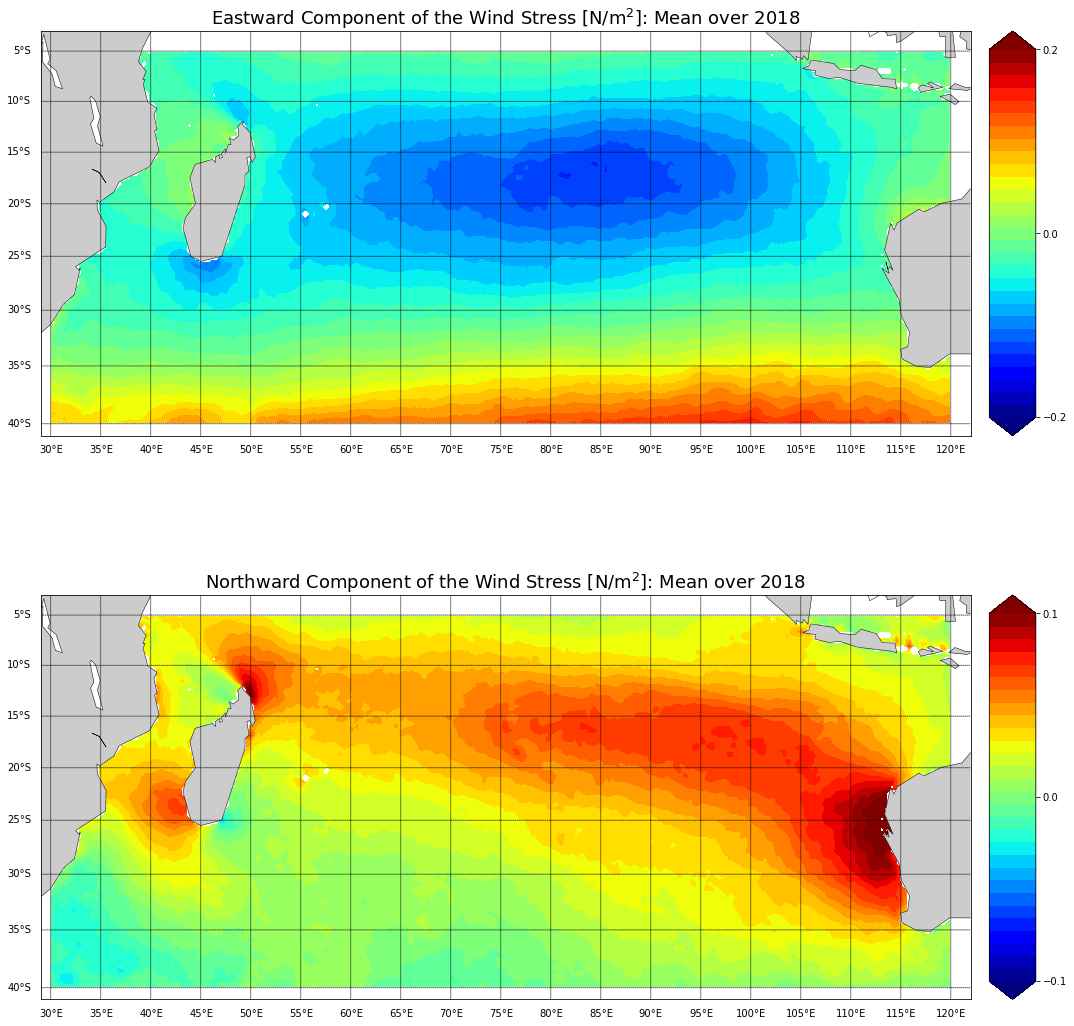

In [230]:
### PLOT
plt.figure(figsize=(15.,16.))

plt.subplot(2,1,1)
m = Basemap(projection='mill', 
            llcrnrlat=lat_min-1, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min-1, urcrnrlon=lon_max+2, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
levs = np.linspace(-taux_lim, taux_lim, 30)
cmesh = m.contourf(lon, lat, taux, levs, cmap='jet', latlon=True, extend='both')
cbar = m.colorbar(cmesh, ticks=[-taux_lim, 0, taux_lim], location='right')
plt.title('Eastward Component of the Wind Stress [N/m$^2$]: Mean over {}'.format(currYear[0]), fontsize=18)

plt.subplot(2,1,2)
m = Basemap(projection='mill', 
            llcrnrlat=lat_min-1, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min-1, urcrnrlon=lon_max+2, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
levs = np.linspace(-tauy_lim, tauy_lim, 30)
cmesh = m.contourf(lon, lat, tauy, levs, cmap='jet', latlon=True, extend='both')
cbar = m.colorbar(cmesh, ticks=[-tauy_lim, 0, tauy_lim], location='right')
plt.title('Northward Component of the Wind Stress [N/m$^2$]: Mean over {}'.format(currYear[0]), fontsize=18)

plt.tight_layout()
plt.show()


Calculate the streamfunction by integrating the Sverdrup balance from the eastern boundary. You will first have to calculate the curl of the wind stress. Note that we have coded a function integrate_sv that can be used to integrate  V  from the eastern boundary:

In [224]:
### START CODE HERE ###

# Grid spacing in the zonal and meridional directions in meters (~2 lines of code)
dx = R*np.cos(lat_1D*deg2rad)*(lon_1D[1]-lon_1D[0])*deg2rad # dx depends on latitude
dy = R*(lat_1D[1]-lat_1D[0])*deg2rad  # dy is constant

# Calculate the curl of the wind stress (~5 lines of code)
dtauydx = np.zeros((Nx,Ny))
for ky in range(Ny):
    dtauydx[:,ky] = np.gradient(tauy[:,ky],dx[ky], axis=0)#
dtauxdy = np.gradient(taux, dy, axis = 1)
windstress_curl = dtauydx - dtauxdy

# Calculate beta (~1 line of code)
beta = 2*Omega*np.cos(lat_1D*deg2rad)/R

# Intergrate Sverdrup balance from eastern boundary (~2 lines of code)
V = 1/beta/rho_ref*windstress_curl
Psi = integrate_sv(V, lon_1D, lat_1D)
print(Psi.shape)
### END CODE HERE ###

(361, 141)


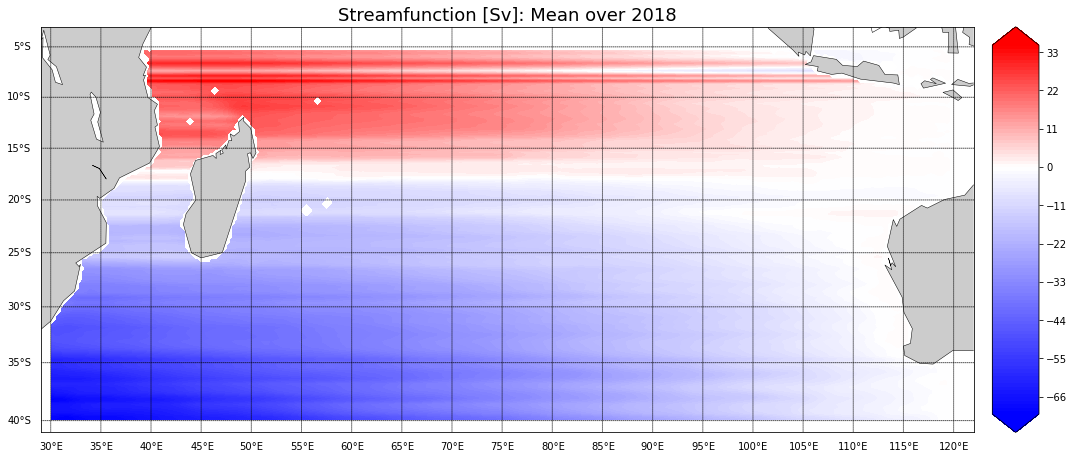

In [225]:
### PLOT
plt.figure(figsize=(15.,16.))

m = Basemap(projection='mill', 
            llcrnrlat=lat_min-1, urcrnrlat=lat_max+2, 
            llcrnrlon=lon_min-1, urcrnrlon=lon_max+2, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
Psimin = round(np.nanmin(Psi))
Psimax = round(np.nanmax(Psi))
levs = np.linspace(Psimin, Psimax, int(Psimax-Psimin+1))
cmesh = m.contourf(lon, lat,  Psi, levs,  cmap='bwr', latlon=True, 
                   extend='both', norm=MidpointNormalize(Psimin, Psimax, 0.))
cbar = m.colorbar(cmesh, location='right')
plt.title('Streamfunction [Sv]: Mean over {}'.format(currYear[0]), fontsize=18)

plt.tight_layout()
plt.show()


#####Looking at the boundaries of any gyres based on a year's monthly averaged SSH

Run the cell below to look at the annually-averaged SSH over this part of the Indian Ocean. In a new Markdown cell, comment on how well the Sverdrup relation predicts the qualitative structure of the subtropical and subpolar gyres. In particular, comment on where the boundary between the gyres is predicted by the Sverdrup relation and where it is observed in SSH.

(47,)
2018
(361, 141)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


1.0 0.0


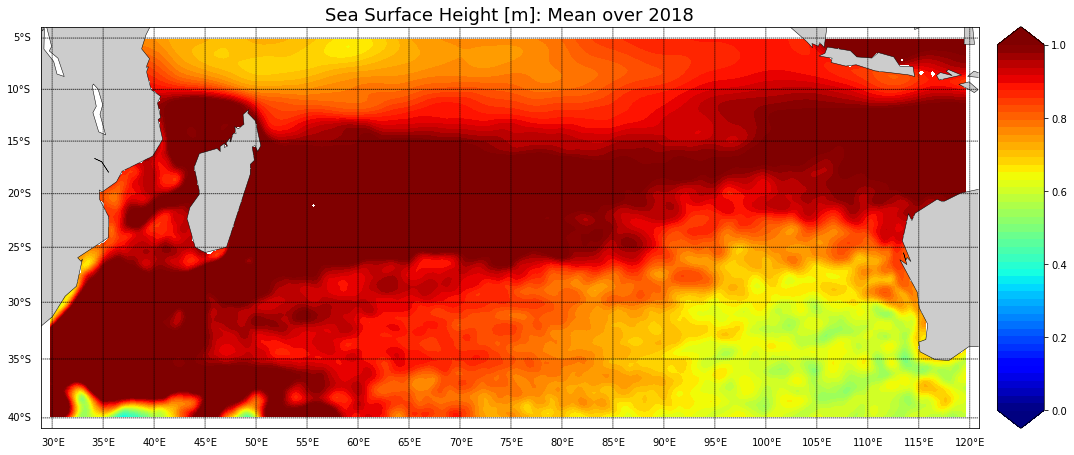

In [226]:
# Extract the Wind Stress monthly average for the latest month (same as that for the SSH and SST data)
yearID = 3 # 0-2015, 1-2016, ... 3-2018
timeStartId = yearID*12
if (timeStartId==3*12) :
    timeStopId = -1
else:
    timeStopId = timeStartId + 12

print(time_base.shape)
currYear = np.unique(pd.DatetimeIndex(time_base.values[timeStartId:timeStopId]).year)
print(currYear[0])
assert(currYear.size==1)

# Extract Monthly Mean SSH in this part of Indian Ocean averaged over "currYear"
SSH_annual = np.nanmean(base_ds['zo'][timeStartId:timeStopId,0,:,:], axis=0).T
print(SSH_annual.shape)
SSH_annual[domain==0] = np.nan

### PLOT SSH_annual
plt.figure(figsize=(15.,16.))
lon_2D, lat_2D = np.meshgrid(lon_base, lat_base, indexing='ij')
m = Basemap(projection='mill', 
            llcrnrlat=np.min(lat_base)-1, urcrnrlat=np.max(lat_base)+1, 
            llcrnrlon=np.min(lon_base)-1, urcrnrlon=np.max(lon_base)+1, 
            resolution='c')
m.fillcontinents()
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
SSHmin = round(np.nanmin(SSH_annual))
SSHmax = round(np.nanmax(SSH_annual))
print(SSHmax, SSHmin)
levs = np.linspace(SSHmin, SSHmax, 50)
cmesh = m.contourf(lon_2D, lat_2D, SSH_annual, levs, cmap='jet', latlon=True, 
                   extend='both')
cbar = m.colorbar(cmesh, ticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], location='right')
plt.title('Sea Surface Height [m]: Mean over {}'.format(currYear[0]), fontsize=18)
plt.tight_layout()
plt.show()

In [231]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [232]:
!jupyter nbconvert --to HTML "/content/drive/My Drive/CEE262I_OceanCirculation/final_project_II.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/CEE262I_OceanCirculation/final_project_II.ipynb to HTML
[NbConvertApp] Writing 2525102 bytes to /content/drive/My Drive/CEE262I_OceanCirculation/final_project_II.html


In [0]:
# SSH_annual = np.nanmean(base_ds['zo'][timeStartId:timeStopId,0,:,:], axis=0).T
# print(SSH_annual.shape)
# SSH_annual[domain==0] = np.nan
# vgrad = np.gradient(SSH_annual)
# SSH_annual_grad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
# ### PLOT SSH_annual-- GRADIENT
# plt.figure(figsize=(15.,16.))
# lon_2D, lat_2D = np.meshgrid(lon_base, lat_base, indexing='ij')
# m = Basemap(projection='mill', 
#             llcrnrlat=np.min(lat_base)-1, urcrnrlat=np.max(lat_base)+1, 
#             llcrnrlon=np.min(lon_base)-1, urcrnrlon=np.max(lon_base)+1, 
#             resolution='c')
# m.fillcontinents()
# m.drawcoastlines(linewidth=0.5)
# m.drawparallels(np.arange(-90.,91,5.), labels=[1,0,0,0])
# m.drawmeridians(np.arange(-180.,181,5.), labels=[0,0,0,1])
# SSHgradmin = round(np.nanmin(SSH_annual_grad),2)
# SSHgradmax = round(np.nanmax(SSH_annual_grad),2)
# print(SSHgradmax, SSHgradmin)
# levsgrad = np.linspace(SSHgradmin, SSHgradmax, 5)
# print(levsgrad)
# cmesh = m.contourf(lon_2D, lat_2D, SSH_annual_grad, levsgrad, cmap='jet', latlon=True, 
#                    extend='both')
# cbar = m.colorbar(cmesh, ticks=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], location='right')
# plt.title('\nabla Sea Surface Height [m]: Avg. over {}'.format(currYear[0]), fontsize=18)
# plt.tight_layout()
# plt.show()